In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf,keras,keras.losses,keras.metrics
from  tensorflow.keras.applications  import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, Dense, concatenate, Flatten
from plot_keras_history import plot_history
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
from scipy.special import expit
from sklearn.metrics import mean_squared_error

In [2]:
data=pd.read_csv("USA.csv")
data.shape

(33000, 307)

In [3]:
data['No. Spans'].value_counts()

11    6000
23    3000
30    3000
25    3000
46    3000
24    3000
6     3000
57    3000
22    3000
44    3000
Name: No. Spans, dtype: int64

In [4]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
print("X ",X.shape)
print("y ",y.shape)
y.value_counts()

X  (33000, 306)
y  (33000,)


0    22182
1    10818
Name: GSNR_class, dtype: int64

In [23]:
#splitting the data set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
#=========converting to array===================
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)
#=========reshaping=============================
y_train=y_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)
#===========printing Shapes======
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(26400, 306)
(26400, 1)
(6600, 306)
(6600, 1)


In [24]:
#===========scalling================
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [25]:
teacher= keras.models.load_model('EU-MODEL.h5')

In [26]:
teacher._name='teacher'
teacher.trainable=False

In [27]:
teacher.summary()

Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               78592     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 122,369
Trainable params: 0
Non-trainable par

In [28]:
teacher.evaluate(X_test,y_test)

207/207 [==============================] - 1s 2ms/step - loss: 5.2363 - accuracy: 0.3362


[5.236291408538818, 0.3362121284008026]

In [29]:
student= tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],),kernel_initializer='he_normal'),
    tf.keras.layers.Dense(64, activation='relu',kernel_initializer='he_normal'),
    tf.keras.layers.Dense(32, activation='relu',kernel_initializer='he_normal'),
    tf.keras.layers.Dense(16, activation='relu',kernel_initializer='he_normal'),
    tf.keras.layers.Dense(1, activation='sigmoid',kernel_initializer='he_normal')
])

In [30]:
student._name='student'

In [31]:
student.summary()

Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               39296     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 50,177
Trainable params: 50,177
Non-trainable params: 0
_________________________________________________________________


In [14]:
scratch_student=keras.models.clone_model(student)

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)#0.001
scratch_student.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
model_history=scratch_student.fit(X_train, y_train, epochs=50, batch_size=X_train.shape[0],validation_data=(X_test,y_test))

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.7504 - accuracy: 0.4947 - val_loss: 0.6628 - val_accuracy: 0.6029
Epoch 2/50
1/1 [==============================] - 0s 146ms/step - loss: 0.6611 - accuracy: 0.6060 - val_loss: 0.6139 - val_accuracy: 0.6648
Epoch 3/50
1/1 [==============================] - 0s 127ms/step - loss: 0.6109 - accuracy: 0.6692 - val_loss: 0.5867 - val_accuracy: 0.6867
Epoch 4/50
1/1 [==============================] - 0s 138ms/step - loss: 0.5825 - accuracy: 0.6912 - val_loss: 0.5700 - val_accuracy: 0.6886
Epoch 5/50
1/1 [==============================] - 0s 137ms/step - loss: 0.5642 - accuracy: 0.6953 - val_loss: 0.5572 - val_accuracy: 0.6918
Epoch 6/50
1/1 [==============================] - 0s 130ms/step - loss: 0.5499 - accuracy: 0.6975 - val_loss: 0.5456 - val_accuracy: 0.6959
Epoch 7/50
1/1 [==============================] - 0s 149ms/step - loss: 0.5370 - accuracy: 0.7024 - val_loss: 0.5340 - val_accuracy: 0.6977
Epoch 8/50
1/1 [=======

In [17]:
scratch_student.evaluate(X_test,y_test)

207/207 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.9986


[0.014738458208739758, 0.9986363649368286]

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

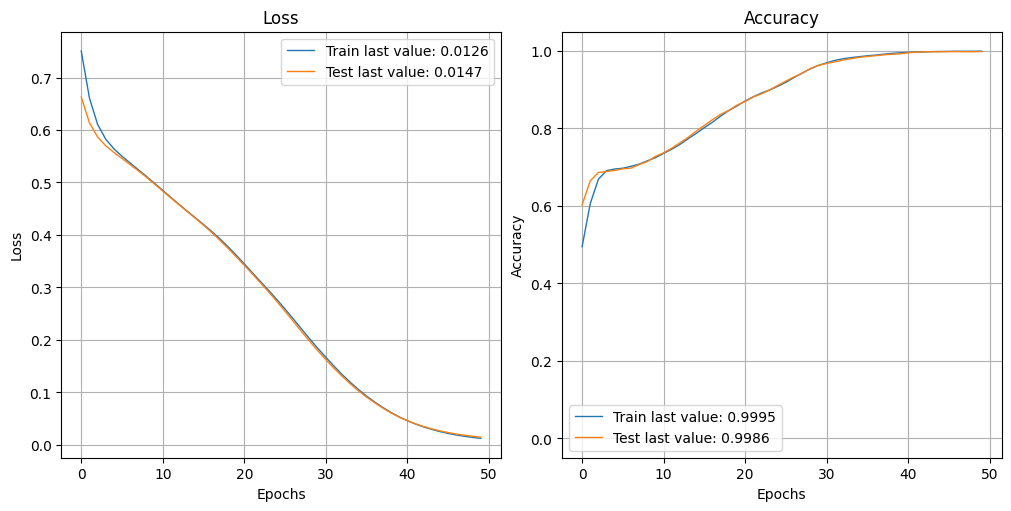

In [18]:
plot_history(model_history,show_standard_deviation=False,show_average=True)

KNOWLEDGE DISTILLATION

In [32]:
class Distiller(keras.Model):
    def __init__(self,student,teacher):
        super(Distiller,self).__init__()
        self.student=student
        self.teacher=teacher
    def compile(self,optimizer,metrics,student_loss_fn,distillation_loss_fn,alpha=0.1,temperature=3):
        super(Distiller,self).compile(optimizer=optimizer,metrics=metrics)
        self.student_loss_fn=student_loss_fn
        self.distillation_loss_fn=distillation_loss_fn
        self.alpha=alpha
        self.temperature=temperature
    def train_step(self,data1):
        x,y=data1
        teacher_predictions=self.teacher(x,training=False)
        with tf.GradientTape() as tape:
            student_predictions=self.student(x,training=True)
            student_loss=self.student_loss_fn(y,student_predictions)
            #distillation_loss=self.distillation_loss_fn(tf.nn.softmax(teacher_predictions/self.temperature,axis=1),tf.nn.softmax(student_predictions/self.temperature,axis=1))
            distillation_loss=self.distillation_loss_fn(teacher_predictions,student_predictions)
            loss=self.alpha*student_loss+(1-self.alpha)*distillation_loss
        modelParameters=self.student.trainable_variables
        gradients=tape.gradient(loss,modelParameters)
        self.optimizer.apply_gradients(zip(gradients,modelParameters))
        self.compiled_metrics.update_state(y,student_predictions)
        
        results={m.name:m.result() for m in self.metrics}
        results.update(
            {'student_loss':student_loss,'distillation_loss':distillation_loss}
        )
        return results
    def test_step(self,data1):
        x,y=data1
        predictions=self.student(x)
        student_loss=self.student_loss_fn(y,predictions)
        self.compiled_metrics.update_state(y, predictions)
        
        results={m.name:m.result() for m in self.metrics}
        results.update(
            {'student_loss': student_loss}
        )
        return results
        
    
            
            
    
            

In [33]:
distiller=Distiller(student=student,teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
    student_loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    distillation_loss_fn=tf.keras.losses.BinaryCrossentropy(),
    alpha=0.3,
    temperature=10,
    
    
)
kd_history=distiller.fit(X_train,y_train,epochs=20,batch_size=X_train.shape[0],validation_data=(X_test,y_test))
distiller.evaluate(X_test,y_test)

Epoch 1/20


c:\Users\Dell pc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 [==============================] - 1s 1s/step - binary_accuracy: 0.4970 - student_loss: 0.7500 - distillation_loss: 0.7751 - val_binary_accuracy: 0.4347 - val_student_loss: 0.8078
Epoch 2/20
1/1 [==============================] - 0s 171ms/step - binary_accuracy: 0.4363 - student_loss: 0.8107 - distillation_loss: 0.6568 - val_binary_accuracy: 0.4106 - val_student_loss: 0.8671
Epoch 3/20
1/1 [==============================] - 0s 183ms/step - binary_accuracy: 0.4031 - student_loss: 0.8706 - distillation_loss: 0.6121 - val_binary_accuracy: 0.4112 - val_student_loss: 0.8755
Epoch 4/20
1/1 [==============================] - 0s 167ms/step - binary_accuracy: 0.4060 - student_loss: 0.8796 - distillation_loss: 0.5918 - val_binary_accuracy: 0.4323 - val_student_loss: 0.8479
Epoch 5/20
1/1 [==============================] - 0s 166ms/step - binary_accuracy: 0.4248 - student_loss: 0.8528 - distillation_loss: 0.5803 - val_binary_accuracy: 0.4656 - val_student_loss: 0.8071
Epoch 6/20
1/1 [========

[0.4724242389202118, 0.6766490340232849]